# Introduction to the Retina project – D7046E @ LTU.SE

This notebook serves as a starting point and playground for investigating what the 1D Retina project is about.
The idea is that you should familiarize yourself with both projects and later on decide which project to focus on (retina/SNN or chatbot/ANN).

In [1]:
# Enable inline plots in the notebook
%matplotlib inline

# Import library functions needed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set default figure size
plt.rcParams['figure.figsize'] = [6,6]

# Function that is used to plot spike times
def rasterplot(ax, x, y, x_label, y_label):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Basic data generator

The following animation illustrates a simple motion detection task. A bright spot is moving across a one-dimensonal array of virtual receptor neurons.

![Concept illustration](https://drive.google.com/uc?export=view&id=1dc4TQ84ui5i9oVnGH9Au5sZfHKzt-2jd)

The task is to determine whether the pattern is moving and whether it is moving towards the left or right. The following code implements a basic spike data generator inspired by the animation above. For simplicity it is assumed that a bright spot is moving at constant speed back and forth, and that one spike is generated when the bright spot is passing over a receptor neuron.

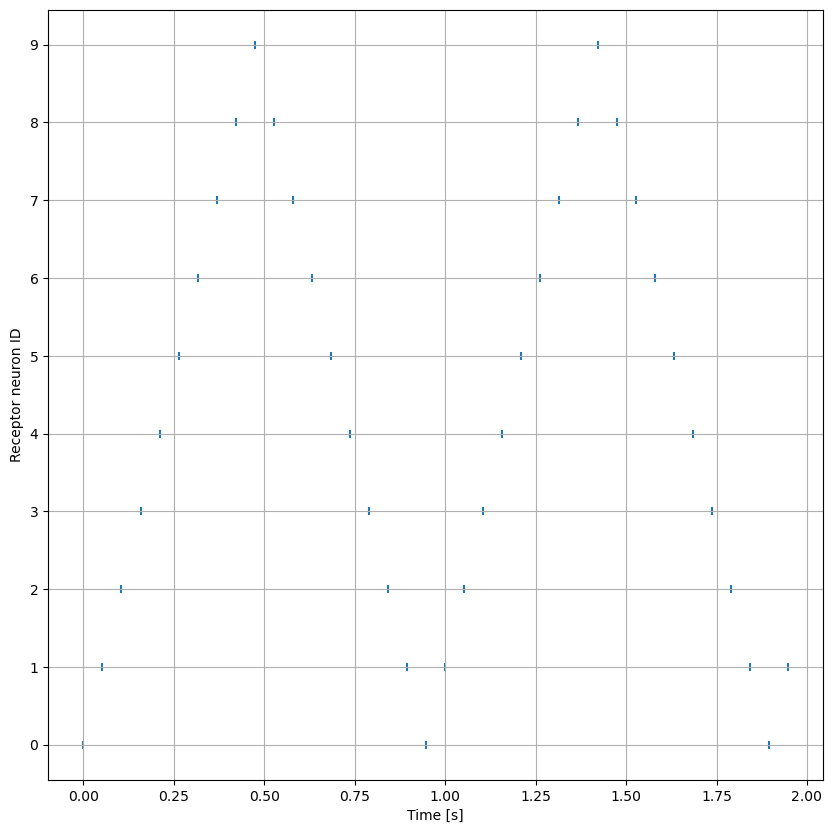

In [32]:
####################################################################################################
# Simulation parameters
dt = 1e-4                    # Timestep
t = np.arange(0,20000)*dt    # Simulation time array t
num_receptors = 10           # Number of receptor neurons
speed = 20                   # Speed of bright spot, number of receptor neurons passed per second
####################################################################################################

plot_t = []                  # Time of spikes
plot_n = []                  # Receptor neuron id's
currtime = 0                 # Time when a spike is fired
neuronid = 0                 # Neuron that fires a spike
stepdir = 1                  # Is the bright spot moving towards the right (1) or left (-1)
timestep = 1.0/(speed-1)     # Time between spikes generated by nearby receptor neurons

# Make placeholders for spike time arrays to be used for SNN simulation
spikes = []
for i in range(num_receptors):
    spikes.append([])

# Generate and plot spikes from receptor neurons
while currtime < t[-1]:
    plot_t.append(currtime)
    plot_n.append(neuronid)
    spikes[neuronid].append(currtime)
    if neuronid == 0 and stepdir == -1:
        stepdir = 1
    elif neuronid == (num_receptors-1) and stepdir == 1:
        stepdir = -1
    neuronid += stepdir
    currtime += timestep
    
# Plot spikes
fig, ax = plt.subplots()
rasterplot(ax, plot_t, plot_n,'Time [s]','Receptor neuron ID')
ax.grid()

# Implement your first motion-detection SNN

There is a direction-selective network example in [Neuronify](https://ovilab.net/neuronify/), which is illustrated below. This network is designed so that the output neuron tends to fire a spike when the inputs are touched from right to left, but not when touched from left to right (with some limitations on the touching speed).

![First network implementation](https://drive.google.com/uc?export=view&id=1ZIyhUCtNebN1StlYCKEnC0qgXMZAF8d-)

Can you simulate this network using the code from SNN Exercise 1 and the input spikes provided by the data generator above? Can you modify the parameters of the simulated network so that it becomes direction selective?

If you succeed with this task then you have designed your first SNN vision system capable of basic motion detection!

**Note:** You need to complete SNN Exercise 1 to acquire the necessary background knowledge for this task.

In [33]:
print(spikes)

[[0, 0.9473684210526312, 1.8947368421052617], [0.05263157894736842, 0.8947368421052628, 0.9999999999999996, 1.8421052631578934, 1.94736842105263], [0.10526315789473684, 0.8421052631578945, 1.052631578947368, 1.789473684210525], [0.15789473684210525, 0.7894736842105261, 1.1052631578947363, 1.7368421052631566], [0.21052631578947367, 0.7368421052631577, 1.1578947368421046, 1.6842105263157883], [0.2631578947368421, 0.6842105263157894, 1.210526315789473, 1.63157894736842], [0.3157894736842105, 0.631578947368421, 1.2631578947368414, 1.5789473684210515], [0.3684210526315789, 0.5789473684210527, 1.3157894736842097, 1.5263157894736832], [0.42105263157894735, 0.5263157894736842, 1.368421052631578, 1.4736842105263148], [0.47368421052631576, 1.4210526315789465]]


In [18]:
# Parameters for Tasks 1–5

# Timestep
dt = 1e-5

# Neuron parameters
R = 95e6
tau_m = 30e-3
u_rest = -65e-3
u_reset = u_rest
u_thres = -50e-3


In [35]:
def lif_cic_neuron(I_syn, u_rest=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3):
    """LIF neuron with a constant input current I_syn"""
    return {
        'type'    : 'lif_cic',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'I_syn'   : I_syn,                     # Postsynaptic current [Ampere]
    }

def lif_neuron(num_synapses, u_rest=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3, tau_syn=50e-3):
    """LIF neuron with current-based synapses (see lecture)"""
    return {
        'type'    : 'lif',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'tau_syn' : tau_syn,                   # Synapse time constant [second] (can also be an array)
        'I_syn'   : np.zeros(num_synapses),    # Postsynaptic currents [Ampere]
        'w_syn'   : np.zeros(num_synapses)     # Synaptic weights [Ampere]
    }

def spike_generator(spike_times):
    """Generates spikes at time points defined by the sorted list 'spike_t'"""
    return {
        'type'      : 'generator',
        'spike_t'   : spike_times              # Array of spike times, separated by at least dt
}

def integrate(dt, t, neurons):
    """This function integrates the membrane potential, synaptic currents etc one timestep dt"""
    for n in neurons:
        if n['type'] == 'lif_cic':
            dudt = (n['u_rest'] - n['u'] + n['R']*n['I_syn']) / n['tau_m']
            n['u'] += dt*dudt
        elif n['type'] == 'lif':
            didt = np.divide(-n['I_syn'], n['tau_syn'])
            n['I_syn'] += dt*didt
            dudt = (n['u_rest'] - n['u'] + n['R']*sum(n['I_syn'])) / n['tau_m']
            n['u'] += dt*dudt

def spikegen(dt, t, neurons):
    """This function implements the non-linear spike generation mechanism"""
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif_cic','lif']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
    return spikes

def snn_update(dt, t, neurons, connections):
    """This function updates the state of a spiking neural network by calling the functions above"""
    integrate(dt, t, neurons)
    spikes = spikegen(dt, t, neurons)
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                if neurons[post]['type'] == 'lif':
                    neurons[post]['I_syn'][syn] += neurons[post]['w_syn'][syn]
                else:
                    print('Error: Spike sent to neuron type without synapses')

    return spikes

In [135]:
from_receptors_excitatory =  350e-12
from_receptors_inhibitory = -200e-12
from_sensor_excitatory = 250e-12
neurons = []
connections = []

n_receptors = [spike_generator(spikes[id]) for id in range(num_receptors)]
neurons.extend(n_receptors)

n_right = [lif_neuron(2) for id in range(num_receptors)]
for offset, neuron in enumerate(n_right):
    neuron['w_syn'][0] = from_receptors_inhibitory
    neuron['w_syn'][1] = from_receptors_excitatory
    if offset + 1 < num_receptors:
        connections.append([len(neurons) + offset, 0, offset + 1])
    connections.append([len(neurons) + offset, 1, offset])
neurons.extend(n_right)

n_left = [lif_neuron(2) for id in range(num_receptors)]
for offset, neuron in enumerate(n_left):
    neuron['w_syn'][0] = from_receptors_inhibitory
    neuron['w_syn'][1] = from_receptors_excitatory
    if offset - 1 >= 0:
        connections.append([len(neurons) + offset, 0, offset - 1])
    connections.append([len(neurons) + offset, 1, offset])
neurons.extend(n_left)

n_moving_right = lif_neuron(num_receptors)
for syn, neuron in enumerate(n_right):
    n_moving_right['w_syn'][syn] = from_sensor_excitatory
    connections.append([3 * num_receptors, syn, 1 * num_receptors + syn])
neurons.append(n_moving_right)

n_moving_left = lif_neuron(num_receptors)
for syn, neuron in enumerate(n_left):
    n_moving_left['w_syn'][syn] = from_sensor_excitatory
    connections.append([3 * num_receptors + 1, syn, 2 * num_receptors + syn])
neurons.append(n_moving_left)



In [136]:
t = 0                                # Reset the simulation time

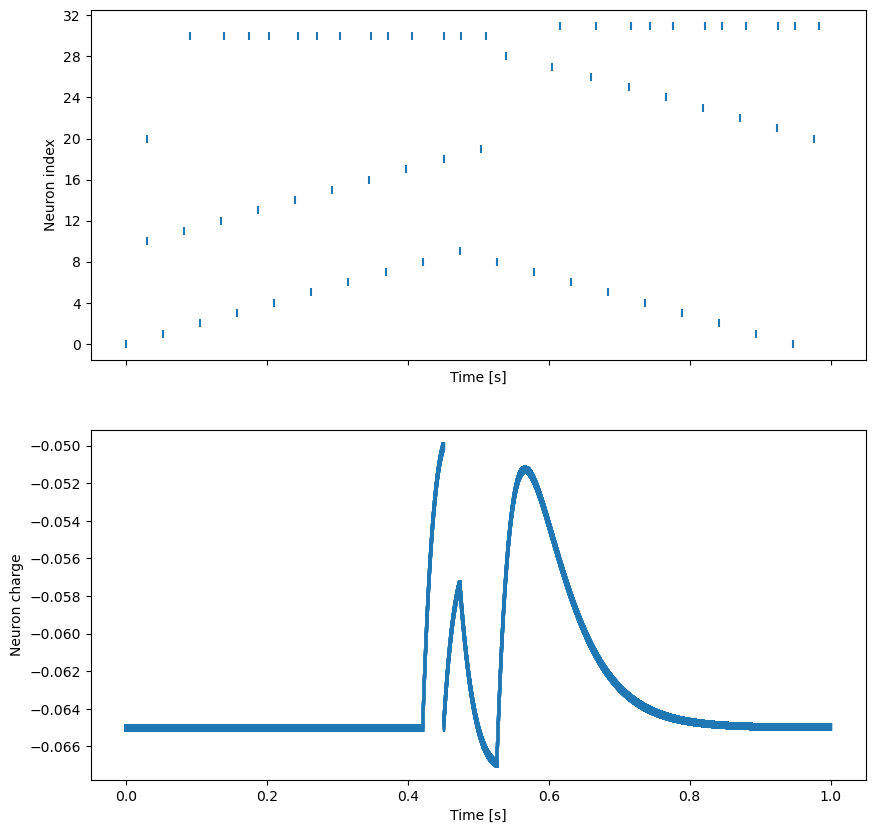

In [137]:
dt = 1e-5

t0 = t
tv = []
u0 = []; probe0 = 18
u1 = []; probe1 = 3 * num_receptors
u2 = []; probe2 = 3 * num_receptors + 1
t_spike = []
n_spike = []


while t < t0+1:

    # Update the network
    spikes_ = snn_update(dt, t, neurons, connections)

    tv.append(t)
    u0.append(neurons[probe0]['u'])
    u1.append(neurons[probe1]['u'])
    u2.append(neurons[probe2]['u'])

    # Store spikes needed for plotting/analysis
    if len(spikes_)>0:
        for s in spikes_:
            t_spike.append(t)
            n_spike.append(s)

    # Timestep completed
    t += dt

plt.rcParams['figure.figsize'] = [10, 10]

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
rasterplot(ax1, t_spike, n_spike,'Time [s]','Neuron index')
rasterplot(ax2, tv, u0, 'Time [s]','Neuron charge')


[0, 10, 20, 1, 11, 30, 2, 12, 30, 3, 30, 13, 30, 4, 14, 30, 5, 30, 15, 30, 6, 16, 30, 7, 30, 17, 30, 8, 18, 30, 9, 30, 19, 30, 8, 28, 7, 27, 31, 6, 26, 31, 5, 25, 31, 4, 31, 24, 31, 3, 23, 31, 2, 31, 22, 31, 1, 21, 31, 0, 31, 20, 31]


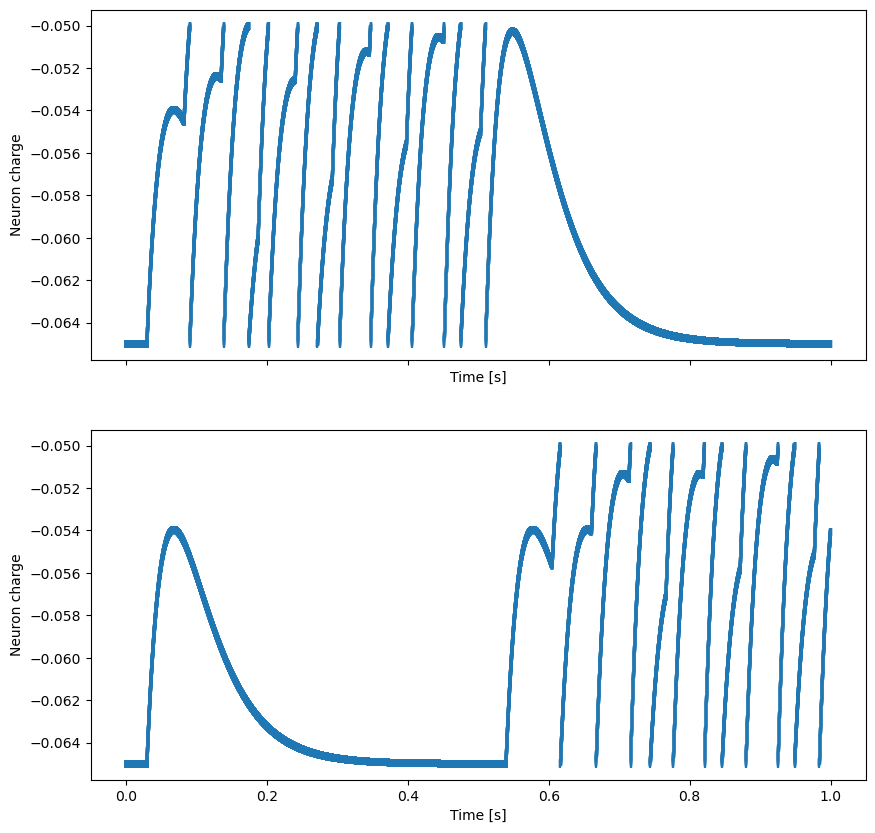

In [138]:
print(n_spike)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
rasterplot(ax1, tv, u1, 'Time [s]','Neuron charge')
rasterplot(ax2, tv, u2, 'Time [s]','Neuron charge')


In [ ]:
# Code for Task 8

CIC_NEURONS = 1 #positivt

nsum = lif_neuron(CIC_NEURONS)
for n in range(CIC_NEURONS):
    nsum['w_syn'][n] = 30000000e-12
neurons = [nsum]
neurons += [lif_cic_neuron((160+3*n)*1e-12) for n in range(CIC_NEURONS)]


connections = [[0, n, n+1] for n in range(CIC_NEURONS)]

dt = 1e-5

t0 = t
tv = []
u_nsum = []
t_spike = []
n_spike = []

while t < t0+2:

    # Update the network
    spikes = snn_update(dt, t, neurons, connections)

    # Store membrane potentials of n1 and n2 for plotting/analysis
    if t > t0+1:
        tv.append(t)
        u_nsum.append(nsum['u'])

        # Store spikes needed for plotting/analysis
        if len(spikes)>0:
            for s in spikes:
                t_spike.append(t)
                n_spike.append(s)


    # Timestep completed
    t += dt

n = [s for s in n_spike if s==0]
print(len(n))
plt.rcParams['figure.figsize'] = [10, 10]

fig,(ax1) = plt.subplots(1,1, sharex=True)
fig2,(ax4) = plt.subplots(1,1, sharex=True)
ax1.plot(tv,u_nsum); ax1.set_ylabel('Membrane potential u_nsum(t)')
rasterplot(ax4, t_spike, n_spike,'Time [s]','Neuron index')


# Further project work 

The challenge for the **1D Retina project** is to develop a more advanced vision system for (1D) motion classification, which is not limited to one specific pattern like the bright spot in the basic data generator above.

For example, you could consider using an open image dataset for training, validation and testing. For testing, the output of a webcam could optionally be considered. The delta modulator concept introduced in SNN Exercise 1 could potentially be used to convert pixel intensities to spikes. Optionally, you can use a [DAVIS346 neuromorphic vision sensor](https://inivation.github.io/inivation-docs/Hardware%20user%20guides/User_guide_-_DAVIS346.html) to record your own dataset.

Some inspiration for the SNN network architecture and training protocol can be obtained also from SNN Exercise 2. The [Reichardt Detector](https://en.wikipedia.org/wiki/Motion_perception#The_Reichardt-Hassenstein_model) is one starting point. For further inspiration, consider for example [motion detection in insects](https://link.springer.com/content/pdf/10.1007/s00359-019-01375-9.pdf).

In addition to considering differnt types of receptor models and SNN architectures for efficient and reliable motion classification, you can consider using other SNN simulators like [Brian2](https://brian2.readthedocs.io). Optionally you can consider using accelerators like [Brian2GeNN](https://brian2genn.readthedocs.io/en/stable/introduction/).

The possibilities for exploration are endless! How does the human retina work?